In [7]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from PIL import Image
import random
from collections import defaultdict
import cv2

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [8]:
import random
import time

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [9]:
train_dir = '/kaggle/input/plant-freshness-or-disease/Plant Leaf Freshness or Disease'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

df.head()

,filepaths,labels
0,/kaggle/input/plant-freshness-or-disease/Plant...,Bottle gourd_Fresh leaf
1,/kaggle/input/plant-freshness-or-disease/Plant...,Bottle gourd_Fresh leaf
2,/kaggle/input/plant-freshness-or-disease/Plant...,Bottle gourd_Fresh leaf
3,/kaggle/input/plant-freshness-or-disease/Plant...,Bottle gourd_Fresh leaf
4,/kaggle/input/plant-freshness-or-disease/Plant...,Bottle gourd_Fresh leaf


In [10]:
df['labels'].nunique()

26

Sample images from each class:


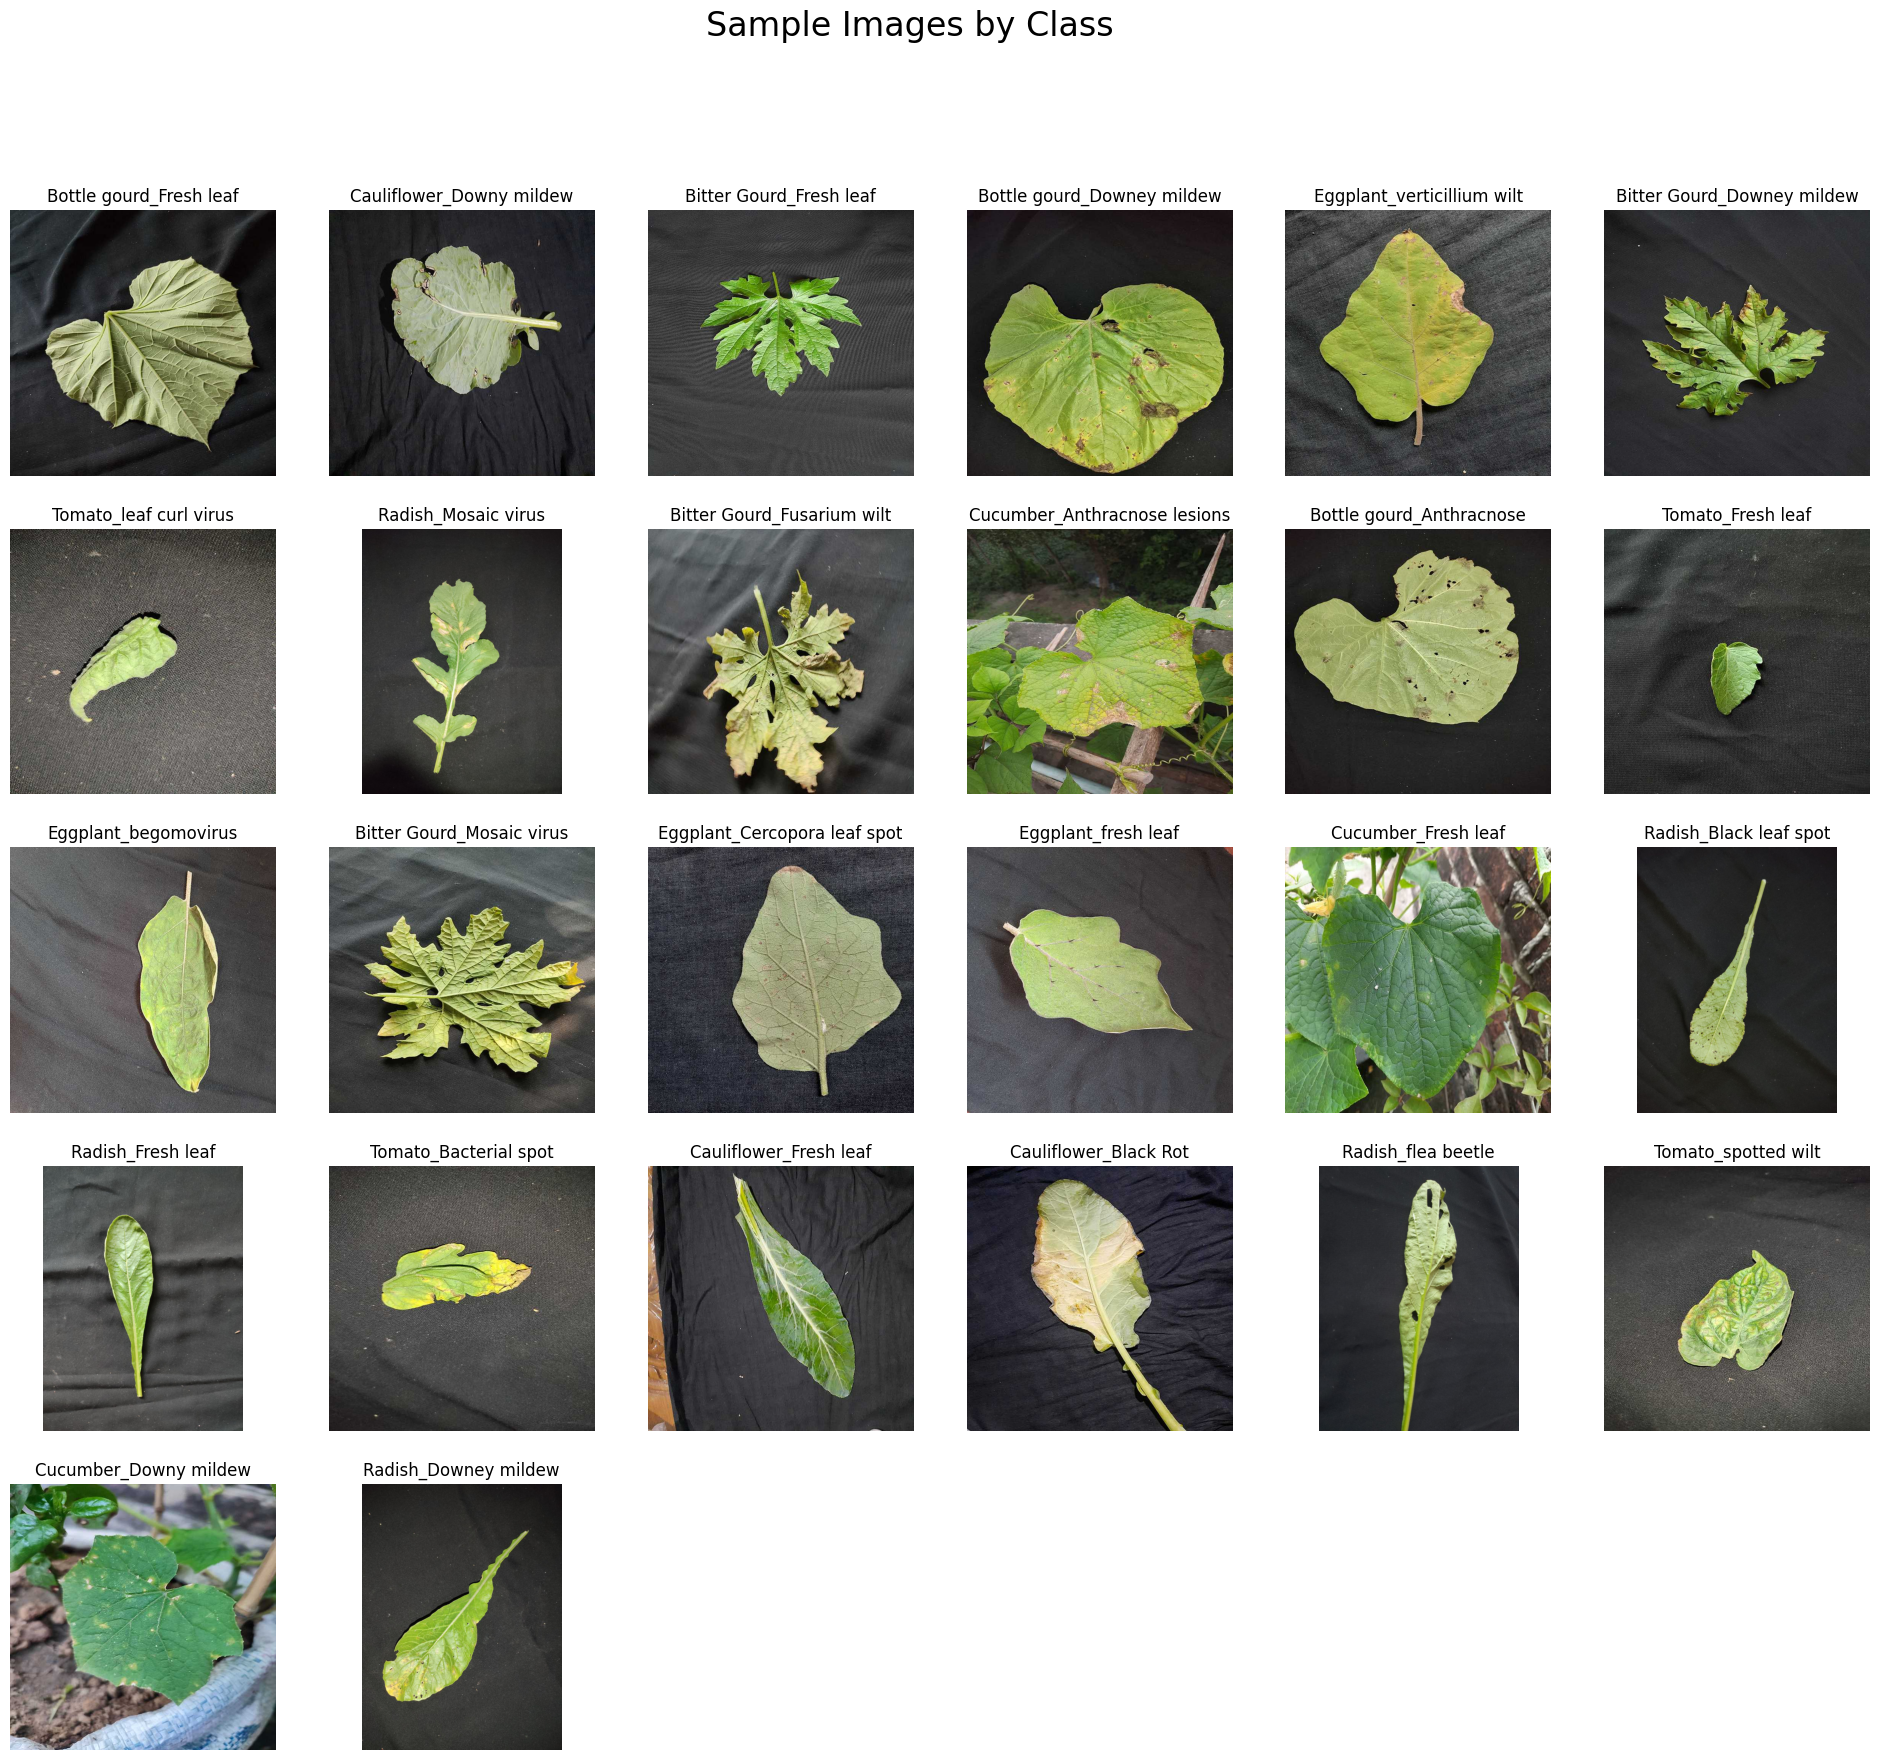

In [11]:
def display_sample_images_by_class(dataframe, title="Sample Images by Class"):
    classes = dataframe['labels'].unique()
    num_classes = len(classes)  # 26 classes
    
    cols = 6  # 6 columns look nice for 26 classes (around 5 rows)
    rows = (num_classes // cols) + int(num_classes % cols != 0)
    
    plt.figure(figsize=(4 * cols, 4 * rows))
    plt.suptitle(title, fontsize=24)
    
    for i, class_name in enumerate(classes):
        class_samples = dataframe[dataframe['labels'] == class_name]
        random_idx = random.randint(0, len(class_samples) - 1)
        img_path = class_samples.iloc[random_idx]['filepaths']
        
        img = np.array(Image.open(img_path))
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"{class_name}", fontsize=12)
        plt.axis('off')
    
    plt.show()

print("Sample images from each class:")
display_sample_images_by_class(df)

# Data Preparation

In [12]:
train_df, other_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)
valid_df, test_df = train_test_split(other_df, train_size = 0.5, shuffle = True, random_state = 42)

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=60,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [14]:
train_gen = tr_gen.flow_from_dataframe(
    train_df, 
    x_col='filepaths', 
    y_col='labels',
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size,
    seed=seed_value
)

train_gen_visual = tr_gen.flow_from_dataframe(
    train_df, 
    x_col='filepaths', 
    y_col='labels',
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size,
    seed=seed_value
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df, 
    x_col='filepaths', 
    y_col='labels',
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False,
    batch_size=batch_size,
    seed=seed_value
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths', 
    y_col='labels',
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size,
    seed=seed_value
)

Found 12469 validated image filenames belonging to 26 classes.
Found 12469 validated image filenames belonging to 26 classes.
Found 1559 validated image filenames belonging to 26 classes.
Found 1559 validated image filenames belonging to 26 classes.


# Model

In [9]:
class_count = len(list(train_gen.class_indices.keys()))

# 1) Model‐embedded preprocessing
inputs = tf.keras.Input(shape=img_shape)

# 2) Backbone
base_model = VGG16(
    input_shape=img_shape,
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

x = base_model(inputs, training=False)

# 3) Your head
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, 
          activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(class_count, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1748361934.691373      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,854,746 (56.67 MB)

 Trainable params: 139,034 (543.10 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

## Callback Functions

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    cooldown=2,
    min_lr=1e-6,
    epsilon=0.001,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=15,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

path_before = '/kaggle/working/VGG16_before.keras'

checkpoint1 = ModelCheckpoint(
    filepath=path_before,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    verbose=1
)

In [ ]:
start_time = time.time()

epochs = 20
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False,
    callbacks=[lr_scheduler, checkpoint1, early_stopping]
)

end_time = time.time()
training_time = end_time - start_time

hours, remainder = divmod(training_time, 3600)
minutes, seconds = divmod(remainder, 60)

print(f"Total training time (s): {training_time:.2f}s")
print(f"Total training time: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

from tensorflow.keras.models import load_model

# Keep these lines:
print("Loading the best model saved by ModelCheckpoint...")
loaded_model = load_model(path_before)

Epoch 1/20


I0000 00:00:1748361941.333041      93 service.cc:148] XLA service 0x79cb3c00f300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748361941.333842      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748361941.761361      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/390 ━━━━━━━━━━━━━━━━━━━━ 29s 76ms/step - accuracy: 0.0391 - loss: 4.5114   

I0000 00:00:1748361950.510536      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.6100 - loss: 1.3575
Epoch 1: val_accuracy improved from -inf to 0.94676, saving model to /kaggle/working/VGG16_before.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 297s 731ms/step - accuracy: 0.6104 - loss: 1.3558 - val_accuracy: 0.9468 - val_loss: 0.1674 - learning_rate: 0.0010
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9101 - loss: 0.2633
Epoch 2: val_accuracy improved from 0.94676 to 0.96216, saving model to /kaggle/working/VGG16_before.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 230s 589ms/step - accuracy: 0.9101 - loss: 0.2633 - val_accuracy: 0.9622 - val_loss: 0.1045 - learning_rate: 0.0010
Epoch 3/20
274/390 ━━━━━━━━━━━━━━━━━━━━ 1:03 546ms/step - accuracy: 0.9340 - loss: 0.1915

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.style.use('default')
fig = plt.figure(figsize=(20, 8), facecolor='white')

# Loss plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_facecolor('white')
ax1.plot(Epochs, tr_loss, 'r', label='Training loss', linewidth=4)
ax1.plot(Epochs, val_loss, 'g', label='Validation loss', linewidth=4)
ax1.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
ax1.set_title('Training and Validation Loss', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(fontsize=14)
ax1.grid(True)

# Accuracy plot
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_facecolor('white')
ax2.plot(Epochs, tr_acc, 'r', label='Training Accuracy', linewidth=4)
ax2.plot(Epochs, val_acc, 'g', label='Validation Accuracy', linewidth=4)
ax2.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
ax2.set_title('Training and Validation Accuracy', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend(fontsize=14)
ax2.grid(True)

plt.tight_layout()
plt.show()


## Eval Loaded Model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_generator, set_name, class_names):
    # Reset generator and get batch size
    data_generator.reset()
    batch_size = data_generator.batch_size
    
    # Get predictions
    y_pred = model.predict(data_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get true labels
    y_true = data_generator.classes
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    # Calculate loss
    loss = model.evaluate(data_generator, verbose=1)[0]
    
    # Create metrics dataframe
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Loss'],
        'Value': [accuracy, precision, recall, f1, loss]
    })
    
    # Display metrics table
    print(f"\n{set_name} Performance Metrics:")
    print(metrics_df)
    
    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {set_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=False, yticklabels=False)
    plt.title(f'Confusion Matrix - {set_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return metrics_df

def evaluate_model_all_sets(model, train_gen, val_gen, test_gen, class_names):
    # Evaluate on all datasets
    train_metrics = evaluate_model(model, train_gen, "Training", class_names)
    val_metrics = evaluate_model(model, val_gen, "Validation", class_names)
    test_metrics = evaluate_model(model, test_gen, "Test", class_names)
    
    # Combine all metrics into a comparison table
    all_metrics = {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics
    }
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Metric': train_metrics['Metric'],
        'Training': train_metrics['Value'],
        'Validation': val_metrics['Value'],
        'Test': test_metrics['Value']
    })
    
    print("\nMetrics Comparison Across Sets:")
    print(comparison_df)
    
    return all_metrics

# Example usage:
class_names = list(test_gen.class_indices.keys())
all_metrics = evaluate_model_all_sets(loaded_model, train_gen_visual, valid_gen, test_gen, class_names)

## Eval Normal Model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_generator, set_name, class_names):
    # Reset generator and get batch size
    data_generator.reset()
    batch_size = data_generator.batch_size
    
    # Get predictions
    y_pred = model.predict(data_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get true labels
    y_true = data_generator.classes
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    # Calculate loss
    loss = model.evaluate(data_generator, verbose=1)[0]
    
    # Create metrics dataframe
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Loss'],
        'Value': [accuracy, precision, recall, f1, loss]
    })
    
    # Display metrics table
    print(f"\n{set_name} Performance Metrics:")
    print(metrics_df)
    
    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {set_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=False, yticklabels=False)
    plt.title(f'Confusion Matrix - {set_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return metrics_df

def evaluate_model_all_sets(model, train_gen, val_gen, test_gen, class_names):
    # Evaluate on all datasets
    train_metrics = evaluate_model(model, train_gen, "Training", class_names)
    val_metrics = evaluate_model(model, val_gen, "Validation", class_names)
    test_metrics = evaluate_model(model, test_gen, "Test", class_names)
    
    # Combine all metrics into a comparison table
    all_metrics = {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics
    }
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Metric': train_metrics['Metric'],
        'Training': train_metrics['Value'],
        'Validation': val_metrics['Value'],
        'Test': test_metrics['Value']
    })
    
    print("\nMetrics Comparison Across Sets:")
    print(comparison_df)
    
    return all_metrics

# Example usage:
class_names = list(test_gen.class_indices.keys())
all_metrics = evaluate_model_all_sets(model, train_gen_visual, valid_gen, test_gen, class_names)

# Fine Tuning

In [ ]:
path_after = '/kaggle/working/VGG16_after.keras'

checkpoint2 = ModelCheckpoint(
    filepath=path_after,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    verbose=1
)

In [ ]:
for layer in base_model.layers[-15:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

start_time = time.time()

fine_tune_epochs = 15
history_fine = model.fit(
    train_gen,
    epochs=fine_tune_epochs,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False,
    callbacks=[lr_scheduler, checkpoint2, early_stopping],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time

hours, remainder = divmod(training_time, 3600)
minutes, seconds = divmod(remainder, 60)

print(f"Total training time (s): {training_time:.2f}s")
print(f"Total training time: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

from tensorflow.keras.models import load_model

# Keep these lines:
print("Loading the best model saved by ModelCheckpoint...")
loaded_model = load_model(path_after)

In [ ]:
# Define needed variables
tr_acc = history_fine.history['accuracy']
tr_loss = history_fine.history['loss']
val_acc = history_fine.history['val_accuracy']
val_loss = history_fine.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.style.use('default')
fig = plt.figure(figsize=(20, 8), facecolor='white')

# Loss plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_facecolor('white')
ax1.plot(Epochs, tr_loss, 'r', label='Training loss', linewidth=4)
ax1.plot(Epochs, val_loss, 'g', label='Validation loss', linewidth=4)
ax1.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
ax1.set_title('Training and Validation Loss', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(fontsize=14)
ax1.grid(True)

# Accuracy plot
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_facecolor('white')
ax2.plot(Epochs, tr_acc, 'r', label='Training Accuracy', linewidth=4)
ax2.plot(Epochs, val_acc, 'g', label='Validation Accuracy', linewidth=4)
ax2.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
ax2.set_title('Training and Validation Accuracy', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend(fontsize=14)
ax2.grid(True)

plt.tight_layout()
plt.show()


## Eval Tune Loaded Model

In [17]:
from tensorflow.keras.models import load_model

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_generator, set_name, class_names):
    # Reset generator and get batch size
    data_generator.reset()
    batch_size = data_generator.batch_size
    
    # Get predictions
    y_pred = model.predict(data_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get true labels
    y_true = data_generator.classes
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    # Calculate loss
    loss = model.evaluate(data_generator, verbose=1)[0]
    
    # Create metrics dataframe
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Loss'],
        'Value': [accuracy, precision, recall, f1, loss]
    })
    
    # Display metrics table
    print(f"\n{set_name} Performance Metrics:")
    print(metrics_df)
    
    # Display classification report
    print(f"\n{set_name} Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    
    return metrics_df

def evaluate_model_all_sets(model, train_gen, val_gen, test_gen, class_names):
    # Evaluate on all datasets
    train_metrics = evaluate_model(model, train_gen, "Training", class_names)
    val_metrics = evaluate_model(model, val_gen, "Validation", class_names)
    test_metrics = evaluate_model(model, test_gen, "Test", class_names)
    
    # Combine all metrics into a comparison table
    all_metrics = {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics
    }
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Metric': train_metrics['Metric'],
        'Training': train_metrics['Value'],
        'Validation': val_metrics['Value'],
        'Test': test_metrics['Value']
    })
    
    print("\nMetrics Comparison Across Sets:")
    print(comparison_df)
    
    return all_metrics

# Example usage:
# class_names = list(test_gen.class_indices.keys())
# all_metrics = evaluate_model_all_sets(loaded_model, train_gen_visual, valid_gen, test_gen, class_names)
class_names = list(test_gen.class_indices.keys())

In [27]:
all_metrics = evaluate_model_all_sets(loaded_model, train_gen_visual, valid_gen, test_gen, class_names)

I0000 00:00:1748363477.217857      91 service.cc:148] XLA service 0x7a508c0024f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748363477.218602      91 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748363477.853293      91 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/390 ━━━━━━━━━━━━━━━━━━━━ 45:56 7s/step

I0000 00:00:1748363480.975330      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


390/390 ━━━━━━━━━━━━━━━━━━━━ 289s 725ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 190s 470ms/step - accuracy: 0.9908 - loss: 0.0134

Training Performance Metrics:
      Metric     Value
0   Accuracy  0.992461
1  Precision  0.992848
2     Recall  0.992461
3   F1 Score  0.992374
4       Loss  0.013190

Training Classification Report:
                              precision    recall  f1-score   support

  Bitter Gourd_Downey mildew       0.99      1.00      1.00       457
     Bitter Gourd_Fresh leaf       1.00      1.00      1.00       448
  Bitter Gourd_Fusarium wilt       0.95      0.81      0.88       396
   Bitter Gourd_Mosaic virus       0.86      0.96      0.91       470
    Bottle gourd_Anthracnose       1.00      1.00      1.00       480
  Bottle gourd_Downey mildew       1.00      1.00      1.00       556
     Bottle gourd_Fresh leaf       1.00      1.00      1.00       408
       Cauliflower_Black Rot       1.00      1.00      1.00       448
    Cauliflower_Downy mildew       1.00    

## Eval Tuned Normal Model

In [2]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/input/dsc_research_group2/keras/default/1/ResNet50_after.keras')

2025-06-02 18:10:56.273034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748887856.471037      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748887856.529459      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1748887868.375629      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_generator, set_name, class_names):
    # Reset generator and get batch size
    data_generator.reset()
    batch_size = data_generator.batch_size
    
    # Get predictions
    y_pred = model.predict(data_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get true labels
    y_true = data_generator.classes
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    # Calculate loss
    loss = model.evaluate(data_generator, verbose=1)[0]
    
    # Create metrics dataframe
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Loss'],
        'Value': [accuracy, precision, recall, f1, loss]
    })
    
    # Display metrics table
    print(f"\n{set_name} Performance Metrics:")
    print(metrics_df)
    
    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {set_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=False, yticklabels=False)
    plt.title(f'Confusion Matrix - {set_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return metrics_df

def evaluate_model(model, data_generator, set_name, class_names):
    # Reset generator and get batch size
    data_generator.reset()
    batch_size = data_generator.batch_size
    
    # Get predictions
    y_pred = model.predict(data_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get true labels
    y_true = data_generator.classes
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    # Calculate loss
    loss = model.evaluate(data_generator, verbose=1)[0]
    
    # Create metrics dataframe
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Loss'],
        'Value': [accuracy, precision, recall, f1, loss]
    })
    
    # Display metrics table
    print(f"\n{set_name} Performance Metrics:")
    print(metrics_df)
    
    # Display classification report
    print(f"\n{set_name} Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    
    return metrics_df

# Example usage:
class_names = list(test_gen.class_indices.keys())
all_metrics = evaluate_model_all_sets(model, train_gen_visual, valid_gen, test_gen, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


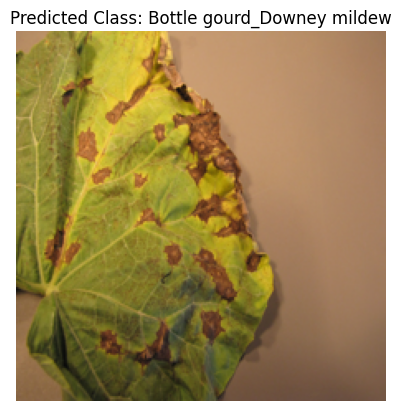

In [19]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input

url = 'https://vegcropshotline.org//wp-content/uploads/2020/12/IMG_5063.jpg' 
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('RGB')

img_resized = img.resize((224, 224)) 
img_array = np.array(img_resized)
img_array = preprocess_input(img_array)  
img_array = np.expand_dims(img_array, axis=0) 

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
predicted_label = class_names[predicted_class]

plt.imshow(img_resized)
plt.title(f'Predicted Class: {predicted_label}')
plt.axis('off')
plt.show()